# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Задача** 

Построить модель, которая по фотографии определит приблизительный возраст человека. Метрикой качества будет MAE.

**Описание данных**

В распоряжении набор фотографий людей с указанием возраста: одна папка со всеми изображениями `(/final_files)` и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. Данные находятся в папке `/datasets/faces/`. 

**Загрузка**

In [1]:
# Импортируем библиотеку pandas для работы с датафреймом
import pandas as pd

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем библиотеку seaborn для построения графиков
import seaborn as sns

# Импортируем библиотеку numpy
import numpy as np

# Импортируем ImageDataGenerator для работы с изображениями
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Исследовательский анализ данных

Загрузим данные CSV-файла `labels.csv` в датафрейм `pandas`.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Выведем информацию о датасете и первые 5 строк
labels.info()

labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датасет `labels` содержит два столбца:

- `file_name` — наименования файла изображения;
- `real_age` — реальный возраст покупателей, данный столбец является **целевым признаком**.

В датасете содержится 7591 строка, то есть мы имеем 7591 фотографию покупателей. 

In [4]:
# Проверим датасет на наличие пропусков
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
# Проверим датасет на наличие явных дубликатов
print('Кол-во явных дубликатов:', labels.duplicated().sum())

# Проверим датасет на наличие неявных дубликатов по столбцу file_name
print('\nКол-во неявных дубликатов по столбцу file_name:', labels['file_name'].duplicated().sum())

Кол-во явных дубликатов: 0

Кол-во неявных дубликатов по столбцу file_name: 0


Пропуски, явные и неявные дубликаты в датасете, отсутствуют.

**Построим график распределения возраста покупателей в выборке.**

In [6]:
gridspec_kw={'height_ratios': [3, 1]}

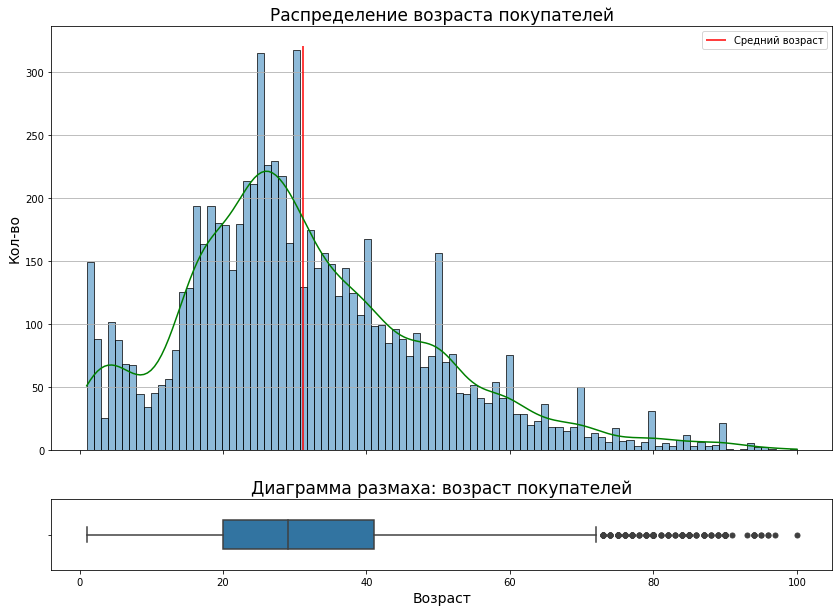


Описательные статистики:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.0,17.0,1.0,20.0,29.0,41.0,100.0


In [7]:
# Построим гарфики по столбцу real_age
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [6, 1]})

# Построим гистограмму 
sns.histplot(data=labels, bins=100, x='real_age', kde=True, ax=axes[0]).lines[0].set_color('green')
axes[0].vlines(labels['real_age'].mean(), ymin=0, ymax=320, color='red', label='Средний возраст')

axes[0].set_title('Распределение возраста покупателей', fontsize=17)
axes[0].set_xlabel('Возраст', fontsize=14)
axes[0].set_ylabel('Кол-во', fontsize=14)
axes[0].legend()
axes[0].grid(True, axis='y')

# Построим диаграмму размаха
sns.boxplot(data=labels, x='real_age', width=0.4, flierprops={"marker": "o"}, ax=axes[1])
axes[1].set_title('Диаграмма размаха: возраст покупателей', fontsize=17)
axes[1].set_xlabel('Возраст', fontsize=14)

plt.show()


# Выведем описательные статистики
print('\nОписательные статистики:')
round(labels['real_age'].describe().to_frame().T, 0)

Целевой признак имеет распределение с отклонением вправо: медиана и среднее находятся правее моды. В выборке представлены фото людей от 1 года до 100 лет. Средний возраст составляет 31 год. Наибольшее количество людей в выборке — молодые люди в возрасте от 18 до 30 лет. При этом в выборке больше всего представлено фотографий людей в возрасте 25 и 30 лет. После отметки в 30 лет мы можем наблюдать обратную зависимость: чем больше возраст, тем меньше количество людей в выборке.

На диаграмме размаха мы также видим правостороннюю асимметрию: медиана ближе к левой границе, а правый ус длиннее. Большая часть данных сосредоточена в левом диапазоне. Межквартильный размах расположен в пределах от 20 до 41 года. Также мы можем заметить наличие выбросов после отметки 72 года.

**Напечатаем 10–15 фотографий и посмотрим, как устроен датасет.**

In [8]:
# Создадим экземпляр с размером выборки 0.002 - это 15 фотографий
datagen = ImageDataGenerator(validation_split=0.002, rescale=1./255)

In [9]:
# Извлечем 15 фотографий из папки
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels, 
    directory= '/datasets/faces/final_files', 
    x_col='file_name', 
    y_col='real_age', 
    subset='validation', 
    class_mode='raw', 
    seed=12345)

Found 15 validated image filenames.


In [10]:
# Получим объекты, у которых пары «картинки — метки»
features, target = next(datagen_flow)

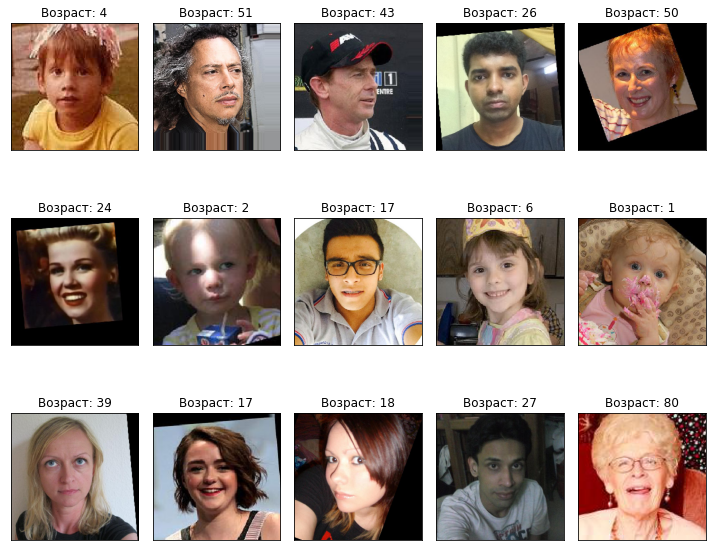

In [11]:
# Выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    # Добавляем подграфик в сетку 3x5
    fig.add_subplot(3, 5, i+1)
    
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    # Для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Итак, по данным фото можно сделать следующие выводы:

- Датасет имеет фотографии в формате `jpg`, имеют 3 цветовых канала `RGB` и квадратную форму.

- В датасете мы имеем фотографии лиц людей разного возраста и пола. Фото сделаны в разных ракурсах, профилях лица, при разном освещении и условиях.

- Часть фотографий имеет поворот и черные рамки (два правых фото с верхнего ряда, два левых фото со второго ряда и два левых фото с последнего ряда). 

- Фотогарфии из датасета размечены верно, и указанный возраст соответствует возрасту соответствующих людей на фотографиях. 

### Промежуточный вывод:

**Провели исследовательский анализ данных датасета и выявили следующее:**

- В датасете `labels` отсутствуют пропуски и дубликаты.
- В выборке представлены фото людей от 1 года до 100 лет. 
- Средний возраст составляет 31 год. 
- Наибольшее количество людей в выобрке — молодые люди в возрасте от 18 до 30 лет. 
- В выборке больше всего представлено фотографий людей в возрасте 25 и 30 лет.
- Диаграмма размаха показала правостороннюю асимметрию: медиана ближе к левой границе, а правый ус длиннее. Большая часть данных сосредоточена в левом диапазоне.
- Межквартильный размах расположен в пределах от 20 до 41 года.

**Изучили фотогарфии датасета и выявили следующее:**

- Датасет имеет 7591 фотографий в формате `jpg`, имеют 3 цветовых канала `RGB` и квадратную форму.

- В датасете мы имеем фотографии лиц людей разного возраста и пола, в разных ракурсах, профилях лица, при разном освещении и условиях.

- Часть фотографий имеет поворот и черные рамки. 

- Фотогарфии из датасета размечены верно, и указанный возраст соответствует возрасту соответствующих людей на фотографиях. 

**Некоторые замечания по распределнию целевого признака:**

- В выборке мы имеем довольно малое количество фото детей в возрасте от 10 до 16 лет, что может сказаться на качестве предсказания моделью возраста в данном диапазоне. Одна из задач — это контролировать добросовестность кассиров при продаже алкоголя, и для более качественного решения этой задачи следует пополнить датасет большим количеством фотографий детей школьного возраста.


- Выборку следует пополнить фотографиями людей старше 40 лет, для более качественного предсказания их возраста, что поможет более качественно и точно предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
 
 
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
    
    train_gen_flow = train_data
    test_gen_flow = test_data

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        validation_steps = len(test_data)

    checkpoint = ModelCheckpoint('best_model', monitor='val_mae', mode='min', save_best_only=True)

    early_stop = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=2)
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[checkpoint, early_stop, reduce_lr],
              verbose=2)

    best_model = load_model('best_model')
    
    return best_model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/50
2025-07-07 11:21:32.383952: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-07-07 11:21:32.681799: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-07-07 11:22:30.888690: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
356/356 - 80s - loss: 202.2944 - mae: 10.2938 - val_loss: 721.8876 - val_mae: 21.9017
Epoch 2/50
356/356 - 66s - loss: 86.7173 - mae: 7.1285 - val_loss: 114.4098 - val_mae: 8.0446
Epoch 3/50
356/356 - 67s - loss: 55.3817 - mae: 5.7246 - val_loss: 86.2512 - val_mae: 6.9042
Epoch 4/50
356/356 - 39s - loss: 44.5942 - mae: 5.0833 - val_loss: 148.0195 - val_mae: 9.6949
Epoch 5/50
356/356 - 68s - loss: 33.1959 - mae: 4.4254 - val_loss: 76.6575 - val_mae: 6.4928
Epoch 6/50
356/356 - 67s - loss: 25.5819 - mae: 3.8982 - val_loss: 70.7912 - val_mae: 6.4787
Epoch 7/50
356/356 - 67s - loss: 20.8839 - mae: 3.4958 - val_loss: 71.0075 - val_mae: 6.2456
Epoch 8/50
356/356 - 39s - loss: 17.6331 - mae: 3.2095 - val_loss: 69.0430 - val_mae: 6.3167
Epoch 9/50
356/356 - 39s - loss: 14.4266 - mae: 2.8892 - val_loss: 81.4759 - val_mae: 6.6268
Epoch 10/50
356/356 - 67s - loss: 11.2481 - mae: 2.5117 - val_loss: 63.0997 - val_mae: 6.0273
Epoch 11/50
356/356 - 67s - loss: 5.9716 - mae: 1.8371 - val_loss: 58.8068 - val_mae: 5.7592
Epoch 12/50
356/356 - 67s - loss: 4.2141 - mae: 1.5290 - val_loss: 58.8500 - val_mae: 5.7552
Epoch 13/50
356/356 - 68s - loss: 2.9921 - mae: 1.2999 - val_loss: 58.5453 - val_mae: 5.7518
Epoch 14/50
356/356 - 39s - loss: 2.5241 - mae: 1.1971 - val_loss: 58.8915 - val_mae: 5.7744
Epoch 15/50
356/356 - 68s - loss: 2.6657 - mae: 1.2457 - val_loss: 58.8260 - val_mae: 5.7274
Epoch 16/50
356/356 - 39s - loss: 3.0938 - mae: 1.3240 - val_loss: 59.3179 - val_mae: 5.8093
Epoch 17/50
356/356 - 39s - loss: 3.7446 - mae: 1.4572 - val_loss: 60.4693 - val_mae: 5.8030
Epoch 18/50
356/356 - 68s - loss: 3.8404 - mae: 1.4580 - val_loss: 57.7666 - val_mae: 5.6473
Epoch 19/50
356/356 - 68s - loss: 2.1719 - mae: 1.0904 - val_loss: 56.9436 - val_mae: 5.6340
Epoch 20/50
356/356 - 39s - loss: 1.4215 - mae: 0.8777 - val_loss: 57.8605 - val_mae: 5.7054
Epoch 21/50
356/356 - 39s - loss: 1.0922 - mae: 0.7785 - val_loss: 57.2039 - val_mae: 5.6384
Epoch 22/50
356/356 - 39s - loss: 0.8420 - mae: 0.6799 - val_loss: 57.1473 - val_mae: 5.6403
2025-07-07 11:42:15.304843: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
119/119 - 11s - loss: 56.9436 - mae: 5.6340

```

## Анализ обученной модели

**Для подготовки данных мы использовали класс `ImageDataGenerator`:**

- Подготовили отдельно *обучающую* и *валидационную* выборки;
- Обозначили входящий признак и целевой признак;
- Установили размер изображений 224х224 (размер, на котором обучалась модель);
- Применили аугментацию к обучающей выборке (отражение по горизонтали);
- Задали размер батча, равный 16;
- Установили параметр `class_mode='raw'` для задачи регрессии;


**Для обучения мы выбрали модель `ResNet50` со следующими параметрами:**

- Ининциализировали веса модели из датасета ImageNet — это помогло улучшить качество модели, чем если обучать с нуля;
- Добавили самостоятельно полносвязный слой с одним нейроном и функцией активации `relu`, так как нам нужен только один нейрон, который вернет предсказание возраста, а функция активации ReLU положительные прогнозы сети не меняет, а все отрицательные — приводит к нулю. Возраст людей меньше нуля быть не может.
- Применили алгоритм `Adam`, для автоматического подбора шага при обучении модели. Уменьшили шаг обучения до `0.0001`, что несколько замедляет скорость обучения, но при этом увеличивает качество модели. 
- Добавили обратные вызовы для более стабильного обучения модели:
    - сохранение весов модели, когда метрика `val_mae` достигает наилучшего значения;
    - раннюю остановку обучения, если метрика `val_mae` не улучшается 3 эпохи подряд;
    - уменьшение шага learning rate, если метрика `val_mae` не улучшается 2 эпохи подряд.
 

Все вышеуказанные параметры позволили получить нам метрику `MAE 5.6340`  на тестовой выборке на 19 эпохе, значит, наша модель может ошибаться в предсказаниях возраста в среднем на 6 лет, что является хорошим показателем, так как по условию задачи значения MAE на тестовой выборке должно быть не больше 8. Веса данной модели сохранены в переменной `best_model`.